## Modules Needed

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
import xgboost as xgb
import random

from lightgbm  import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import  make_scorer,  mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


#### Import Train and Test and describe train set

In [2]:
train = pd.read_csv("train.csv", index_col="id")
train_extra = pd.read_csv("training_extra.csv", index_col="id")
test = pd.read_csv("test.csv", index_col="id")
train_c  = pd.concat([train, train_extra], axis=0,ignore_index=True)

y_train_c = train_c["Price"].copy()
x_train_c = train_c.copy()
x_train_c = train_c.drop(["Price"], axis="columns")

train_y = train["Price"].copy()
train_x = train.copy()
train_x = train_x.drop(["Price"], axis="columns")
test_x = test.copy()

train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 299999
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 290295 non-null  object 
 1   Material              291653 non-null  object 
 2   Size                  293405 non-null  object 
 3   Compartments          300000 non-null  float64
 4   Laptop Compartment    292556 non-null  object 
 5   Waterproof            292950 non-null  object 
 6   Style                 292030 non-null  object 
 7   Color                 290050 non-null  object 
 8   Weight Capacity (kg)  299862 non-null  float64
dtypes: float64(2), object(7)
memory usage: 22.9+ MB


In [3]:
#Categorical and numeric columns
cat_col = [x for x, y in zip(train_x.columns, train_x.dtypes) if y in ["object", "category"] ]
num_col = [x for x, y in zip(train_x.columns, train_x.dtypes) if y not in ["object", "category"] ]

train_x[num_col].head(3)

,Compartments,Weight Capacity (kg)
id,,
0,7.0,11.611723
1,10.0,27.078537
2,2.0,16.643760


#### Encode our object fields to categories

In [4]:
def object_cat (df):
    for column, type in zip(df.columns,df.dtypes):
        if type == "object":
            df[column] = df[column].astype("category")

object_cat(train_x)
object_cat(test_x)

display(train_x.info())

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 299999
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Brand                 290295 non-null  category
 1   Material              291653 non-null  category
 2   Size                  293405 non-null  category
 3   Compartments          300000 non-null  float64 
 4   Laptop Compartment    292556 non-null  category
 5   Waterproof            292950 non-null  category
 6   Style                 292030 non-null  category
 7   Color                 290050 non-null  category
 8   Weight Capacity (kg)  299862 non-null  float64 
dtypes: category(7), float64(2)
memory usage: 8.9 MB


None

### Exploratory Analysis

In [5]:
palletes = ["coolwarm","pastel","Set2"]
fig, axes = plt.subplots(len(train_x.columns), 2, figsize=(60, 20*len(train_x.columns)), 
                         constrained_layout=True)

for axs, col, type in zip(axes, train_x.columns, train_x.dtypes):
    if type == "category":
        sns.countplot(data=train_x, x=col, ax=axs[0], palette=palletes[0])
        axs[0].set_title(f"Countplot of {col}", fontsize=25)
        axs[0].set_xlabel(col, fontsize=25)
        axs[0].set_ylabel("count" ,fontsize=25)
        axs[0].tick_params(axis='both', labelsize=20)

        sns.boxplot(data=train, y=col,x="Price", ax=axs[1], palette=palletes[1], orient="h")
        axs[1].set_title(f"Boxplot of {col}", fontsize=25)
        axs[1].set_xlabel(col, fontsize=25)
        #axs[1].set_ylabel("count" ,fontsize=25)
        axs[1].tick_params(axis='both', labelsize=20)
    else:
        sns.kdeplot(data=train, x=col, ax=axs[0])
        axs[0].set_title(f"Countplot of {col}", fontsize=25)
        axs[0].set_xlabel(col, fontsize=25)
        axs[0].set_ylabel("Price" ,fontsize=25)
        axs[0].tick_params(axis='both', labelsize=20)

        sns.histplot(data=train, x=col, bins = 10,ax=axs[1], palette=palletes[2], kde=True)
        axs[1].set_title(f"Boxplot of {col}", fontsize=25)
        axs[1].set_xlabel(col, fontsize=25)
        #axs[1].set_ylabel("count" ,fontsize=25)
        axs[1].tick_params(axis='both', labelsize=20)
        
        

In [6]:
##coded cat columns making suitable for ML
def object_cat (df):
    for column, type in zip(df.columns,df.dtypes):
        if type == "category":
            df[column] = df[column].astype("category").cat.codes
        elif type == "object":
            df[column] = df[column].astype("category").cat.codes

object_cat(train_x)
object_cat(test_x)

display(train_x.info())

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 299999
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 300000 non-null  int8   
 1   Material              300000 non-null  int8   
 2   Size                  300000 non-null  int8   
 3   Compartments          300000 non-null  float64
 4   Laptop Compartment    300000 non-null  int8   
 5   Waterproof            300000 non-null  int8   
 6   Style                 300000 non-null  int8   
 7   Color                 300000 non-null  int8   
 8   Weight Capacity (kg)  299862 non-null  float64
dtypes: float64(2), int8(7)
memory usage: 8.9 MB


None

In [7]:
#fill missing values with median
train_x[num_col].fillna(train_x[num_col].median(),inplace=True)
test_x[num_col].fillna(test_x[num_col].median(),inplace=True)

In [8]:
#Scale train_x test_x
scale = StandardScaler()
train_x_scaled = pd.DataFrame(scale.fit_transform(train_x), columns= train_x.columns)
test_x_scaled = pd.DataFrame(scale.transform(test_x), columns= train_x.columns)

## Model Creation 1#

In [9]:
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [10]:
param_grid = list(zip(
    # n_estimators
    [500,700,850, 1000, 1200],
    # learning_rate
    [0.1,0.075, 0.05, 0.025, 0.01],
    # max_depth
    [ 5, 6, 7, 8, 9],
    # subsample
    [0.6, 0.65, 0.7, 0.75, 0.8,],
    # colsample_bytree 
    [0.55, 0.6, 0.65, 0.7, 0.75]
))

rmse_scorer = make_scorer(mean_squared_error, squared=False)

test_acc =[]
for n_est, lr, max_d, sub_s, col_s in param_grid:
    cat_col = [f"name:{col}" for col in cat_col] 
    ls = LGBMRegressor(n_estimators=n_est, random_state=0,n_jobs=-1,
                       learning_rate=lr,max_depth=max_d,force_col_wise=True,
                       #categorical_feature=cat_col,
                       subsample=sub_s,subsample_freq=1,
                       verbose=-1, #supress logss due to vast iter
                         metric="rmse")
    # Cross-validation
    cv_rmse = cross_val_score(ls, train_x, train_y, cv=5, scoring=rmse_scorer)
    ls.fit(train_x,train_y)
    y_pred = ls.predict(x_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    test_acc.append(rmse)
    print(f"n_estimators: {n_est} | Training Mean RMSE: {cv_rmse.mean():.4f} | Test RMSE: {rmse} ")

n_estimators: 500 | Training Mean RMSE: 39.1066 | Test RMSE: 38.452254773848516 
n_estimators: 700 | Training Mean RMSE: 39.1101 | Test RMSE: 38.315221300183396 
n_estimators: 850 | Training Mean RMSE: 39.0725 | Test RMSE: 38.33567505981952 
n_estimators: 1000 | Training Mean RMSE: 39.0205 | Test RMSE: 38.50569512406489 
n_estimators: 1200 | Training Mean RMSE: 38.9972 | Test RMSE: 38.68161357292122 


In [11]:
best_index = np.argmax(test_acc)
params = param_grid[best_index]
params


(1200, 0.01, 9, 0.8, 0.75)

In [12]:
#Best Model based on test_rmse

n_est, lr, max_d, sub_s, col_s = params
cat_col = [f"name:{col}" for col in cat_col] 
ls = LGBMRegressor(n_estimators=n_est, random_state=0,n_jobs=-1,
                       learning_rate=lr,max_depth=max_d,force_col_wise=True,
                       subsample=sub_s,subsample_freq=1,
                       verbose=-1, 
                         metric="rmse")
# Cross-validation
cv_rmse = cross_val_score(ls, train_x, train_y, cv=5, scoring=rmse_scorer)
ls.fit(train_x,train_y)
object_cat(x_train_c)
y_pred = ls.predict(x_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
y_pred_e = ls.predict(x_train_c)
rmse_e = mean_squared_error(y_train_c, y_pred_e, squared=False)
print(f"Params \n|n_estimators: {n_est} \n|Training Mean RMSE: {cv_rmse.mean():.4f} \n|Train_extra RMSE: {rmse_e} \n|Test RMSE: {rmse}")



Params 
|n_estimators: 1200 
|Training Mean RMSE: 38.9972 
|Train_extra RMSE: 38.877596154973965 
|Test RMSE: 38.68161357292122


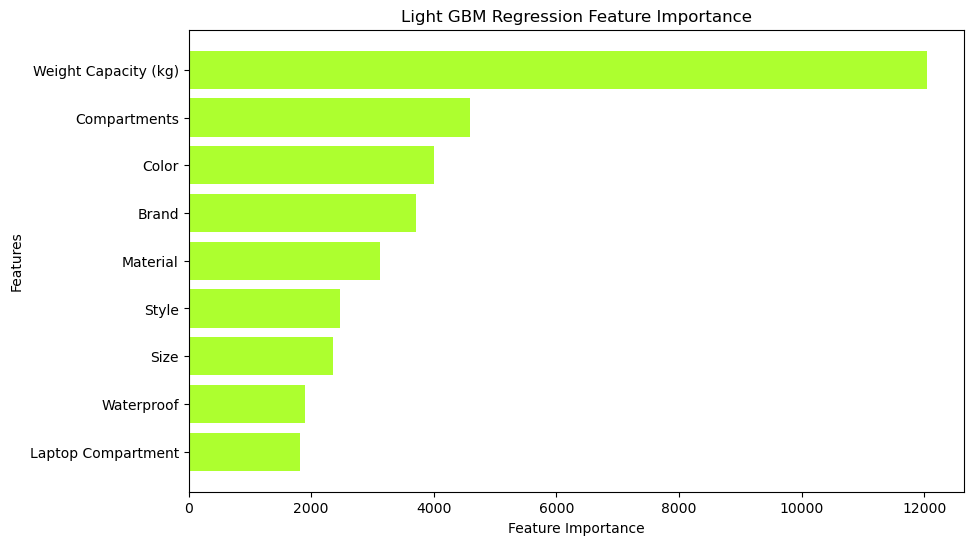

In [13]:
# Plot feature importances
importance_xgb = ls.feature_importances_
sorted_idx = np.argsort(importance_xgb)[::-1]
features = train_x.columns

plt.figure(figsize=(10, 6))
plt.barh([features[i] for i in sorted_idx], importance_xgb[sorted_idx], color="greenyellow")
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Light GBM Regression Feature Importance')
plt.gca().invert_yaxis()  
plt.show()

In [14]:
y_pred_test = ls.predict(test_x)
submission = pd.DataFrame({'id': test_x.index, 'Price': y_pred_test})
submission.to_csv('submission.csv', index=False)
display(submission.head())

,id,Price
0,300000,81.862113
1,300001,82.360414
2,300002,83.356679
3,300003,81.183523
4,300004,77.945388
